# Load libraries and set device up

In [1]:
import numpy    as np
import torch.nn as nn
import os
import torch

import libraries.model   as clm
import libraries.dataset as cld

from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
target = 'EPA'
folder = 'MP-EPA'

target_folder = f'models/{folder}'

In [3]:
files_names = {
    'dataset_name':      f'{target_folder}/dataset.pt',
    'train_dt_std_name': f'{target_folder}/train_dataset_std.pt',
    'val_dt_std_name':   f'{target_folder}/val_dataset_std.pt',
    'test_dt_std_name':  f'{target_folder}/test_dataset_std.pt',
    'std_param_name':    f'{target_folder}/standardized_parameters.json',
    'dt_param_name':     f'{target_folder}/dataset_parameters.json',
    'uncert_data_name':  f'{target_folder}/uncertainty_data.json',
    'model_name':        f'{target_folder}/model.pt',
    'model_param_name':  f'{target_folder}/model_parameters.json'
}
cld.save_json(files_names, f'{target_folder}/files_names.json')

# Define parameters

In [4]:
n_epochs =      300
batch_size =    128
learning_rate = 0.001
dropout =       0.1
patience =      n_epochs
delta =         2
train_ratio =   0.8
test_ratio =    0.1  # val_ratio = 1 - train_ratio - test_ratio

model_parameters = {
    'n_epochs':      n_epochs,
    'batch_size':    batch_size,
    'learning_rate': learning_rate,
    'dropout':       dropout,
    'patience':      patience,
    'delta':         delta,
    'train_ratio':   train_ratio,
    'test_ratio':    test_ratio
}
cld.save_json(model_parameters, files_names['model_param_name'])

# Generate or load graph database for training

In [5]:
# Try loading the training datasets directly, else generate them
try:
    train_dataset, val_dataset, test_dataset, standardized_parameters = cld.load_datasets(files_names)

except FileNotFoundError:
    if not os.path.exists(files_names['dataset_name']):
        # Generate data
        cld.generate_dataset('datasets/bandgap-MChX',
                             targets=['bandgap'],
                             data_folder=target_folder)

    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(files_names['dataset_name'], weights_only=False)

    # Load dataset parameters
    dataset_parameters = cld.load_json(files_names['dt_param_name'])

    # Determine the index for the desired property
    target_idx = [idx for idx, t in enumerate(dataset_parameters['target']) if t == target][0]

    # Select the target we want
    for data in dataset:
        data.y = torch.tensor([data.y[target_idx]], dtype=torch.float)

    # Split datasets
    train_dataset, val_dataset, test_dataset = cld.split_dataset(train_ratio, test_ratio, dataset)
    del dataset  # Free up CUDA memory

    # Standardize train dataset
    train_dataset, standardized_parameters = cld.standardize_dataset(train_dataset)

    # Standardize test and validation datasets with train parameters
    val_dataset  = cld.standardize_dataset_from_keys(val_dataset,  standardized_parameters)
    test_dataset = cld.standardize_dataset_from_keys(test_dataset, standardized_parameters)

    # Save datasets
    cld.save_datasets(train_dataset, val_dataset, test_dataset, files_names)

    # Save standardized parameters
    cld.save_json(standardized_parameters, files_names['std_param_name'])

# Defining target factor
target_factor = np.array(standardized_parameters['target_std']) / standardized_parameters['scale']
targe_mean = standardized_parameters['target_mean']

Number of training   graphs: 35600
Number of validation graphs: 4450
Number of testing    graphs: 4450


Define data loaders.

In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset[0].num_node_features

# Generate Graph Neural Network model

In [7]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model_name'], purpose='train')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion

In [8]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = clm.EarlyStopping(patience=patience, delta=delta, model_name=files_names['model_name'])

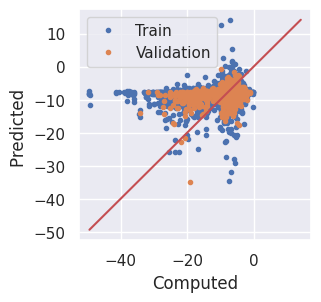

Epoch: 1, Train MAE: 3.3895, Val MAE: 3.0986
Epoch: 2, Train MAE: 3.3088, Val MAE: 3.0597
Epoch: 3, Train MAE: 3.2760, Val MAE: 3.0432
Epoch: 4, Train MAE: 3.2545, Val MAE: 3.0561
Epoch: 5, Train MAE: 3.2509, Val MAE: 3.0332
Epoch: 6, Train MAE: 3.2428, Val MAE: 3.0345
Epoch: 7, Train MAE: 3.2147, Val MAE: 3.0319
Epoch: 8, Train MAE: 3.2142, Val MAE: 3.0208
Epoch: 9, Train MAE: 3.2014, Val MAE: 3.0385
Epoch: 10, Train MAE: 3.1927, Val MAE: 3.0047


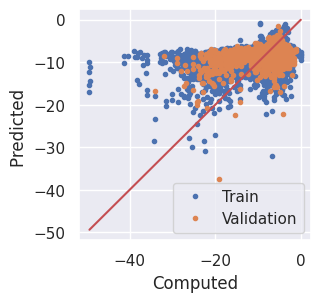

Epoch: 11, Train MAE: 3.1815, Val MAE: 3.0172
Epoch: 12, Train MAE: 3.1787, Val MAE: 3.0178
Epoch: 13, Train MAE: 3.1722, Val MAE: 3.0086
Epoch: 14, Train MAE: 3.1576, Val MAE: 3.0230
Epoch: 15, Train MAE: 3.1516, Val MAE: 3.0019
Epoch: 16, Train MAE: 3.1425, Val MAE: 2.9871
Epoch: 17, Train MAE: 3.1473, Val MAE: 2.9686
Epoch: 18, Train MAE: 3.1352, Val MAE: 2.9719
Epoch: 19, Train MAE: 3.1203, Val MAE: 2.9933
Epoch: 20, Train MAE: 3.1178, Val MAE: 2.9780


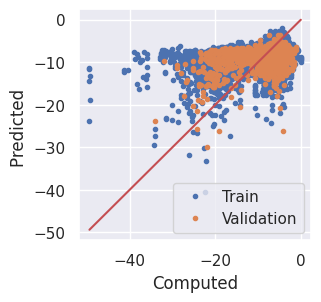

Epoch: 21, Train MAE: 3.1174, Val MAE: 2.9797
Epoch: 22, Train MAE: 3.1061, Val MAE: 2.9801
Epoch: 23, Train MAE: 3.1086, Val MAE: 2.9878
Epoch: 24, Train MAE: 3.1025, Val MAE: 2.9482
Epoch: 25, Train MAE: 3.0784, Val MAE: 2.9560
Epoch: 26, Train MAE: 3.0978, Val MAE: 2.9583
Epoch: 27, Train MAE: 3.0732, Val MAE: 2.9348
Epoch: 28, Train MAE: 3.0837, Val MAE: 3.0024
Epoch: 29, Train MAE: 3.0648, Val MAE: 2.9433
Epoch: 30, Train MAE: 3.0796, Val MAE: 2.9825


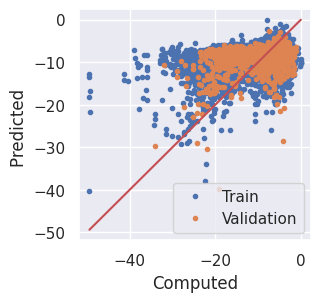

Epoch: 31, Train MAE: 3.0512, Val MAE: 2.9799
Epoch: 32, Train MAE: 3.0516, Val MAE: 2.9790
Epoch: 33, Train MAE: 3.0553, Val MAE: 2.9511
Epoch: 34, Train MAE: 3.0425, Val MAE: 2.9383
Epoch: 35, Train MAE: 3.0388, Val MAE: 3.0025
Epoch: 36, Train MAE: 3.0421, Val MAE: 2.9367
Epoch: 37, Train MAE: 3.0377, Val MAE: 2.9085
Epoch: 38, Train MAE: 3.0291, Val MAE: 2.9173
Epoch: 39, Train MAE: 3.0349, Val MAE: 2.9490
Epoch: 40, Train MAE: 3.0236, Val MAE: 2.9547


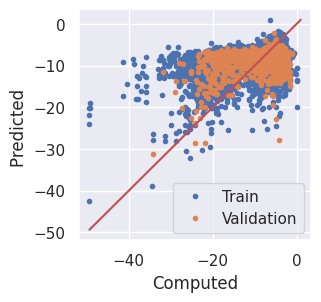

Epoch: 41, Train MAE: 3.0100, Val MAE: 2.9248
Epoch: 42, Train MAE: 3.0204, Val MAE: 2.9503
Epoch: 43, Train MAE: 3.0025, Val MAE: 2.9040
Epoch: 44, Train MAE: 3.0051, Val MAE: 2.9451
Epoch: 45, Train MAE: 3.0145, Val MAE: 2.9433
Epoch: 46, Train MAE: 3.0017, Val MAE: 2.9547
Epoch: 47, Train MAE: 3.0000, Val MAE: 2.9137
Epoch: 48, Train MAE: 3.0020, Val MAE: 2.9192
Epoch: 49, Train MAE: 2.9742, Val MAE: 2.9429
Epoch: 50, Train MAE: 2.9770, Val MAE: 2.9724


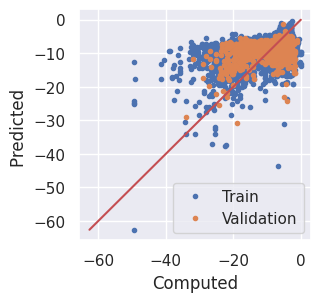

Epoch: 51, Train MAE: 2.9928, Val MAE: 2.9296
Epoch: 52, Train MAE: 2.9808, Val MAE: 2.9463
Epoch: 53, Train MAE: 2.9664, Val MAE: 2.9220
Epoch: 54, Train MAE: 2.9811, Val MAE: 2.9079
Epoch: 55, Train MAE: 2.9599, Val MAE: 2.8947
Epoch: 56, Train MAE: 2.9733, Val MAE: 2.9172
Epoch: 57, Train MAE: 2.9550, Val MAE: 2.9348
Epoch: 58, Train MAE: 2.9631, Val MAE: 2.9298
Epoch: 59, Train MAE: 2.9507, Val MAE: 2.9164
Epoch: 60, Train MAE: 2.9478, Val MAE: 2.9114


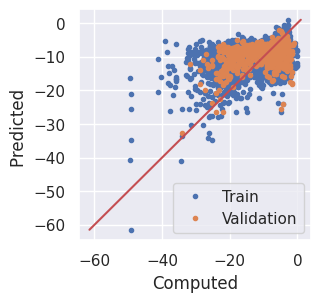

Epoch: 61, Train MAE: 2.9370, Val MAE: 2.9157
Epoch: 62, Train MAE: 2.9477, Val MAE: 2.9029
Epoch: 63, Train MAE: 2.9343, Val MAE: 2.8970
Epoch: 64, Train MAE: 2.9306, Val MAE: 2.9102
Epoch: 65, Train MAE: 2.9937, Val MAE: 2.8944
Epoch: 66, Train MAE: 2.9466, Val MAE: 2.9077
Epoch: 67, Train MAE: 2.9315, Val MAE: 2.9366
Epoch: 68, Train MAE: 2.9531, Val MAE: 2.9092
Epoch: 69, Train MAE: 2.9277, Val MAE: 2.8763
Epoch: 70, Train MAE: 2.9073, Val MAE: 2.8620


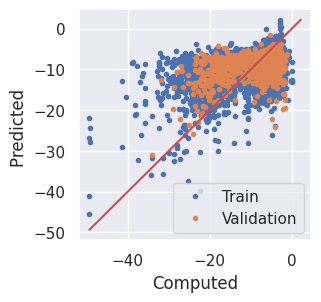

Epoch: 71, Train MAE: 2.9202, Val MAE: 2.8985
Epoch: 72, Train MAE: 2.9113, Val MAE: 2.8752
Epoch: 73, Train MAE: 2.9061, Val MAE: 2.8932
Epoch: 74, Train MAE: 2.9234, Val MAE: 2.8931
Epoch: 75, Train MAE: 2.8982, Val MAE: 2.8913
Epoch: 76, Train MAE: 2.9007, Val MAE: 2.8776
Epoch: 77, Train MAE: 2.9101, Val MAE: 2.8928
Epoch: 78, Train MAE: 2.8871, Val MAE: 2.9001
Epoch: 79, Train MAE: 2.9134, Val MAE: 2.9021
Epoch: 80, Train MAE: 2.9147, Val MAE: 2.8854


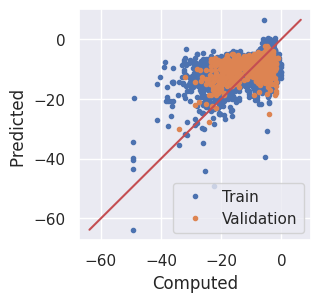

Epoch: 81, Train MAE: 2.9265, Val MAE: 2.8946
Epoch: 82, Train MAE: 2.8891, Val MAE: 2.9132
Epoch: 83, Train MAE: 2.8690, Val MAE: 2.8932
Epoch: 84, Train MAE: 2.8767, Val MAE: 2.8552
Epoch: 85, Train MAE: 2.8825, Val MAE: 2.9230
Epoch: 86, Train MAE: 2.8857, Val MAE: 2.9142
Epoch: 87, Train MAE: 2.8653, Val MAE: 2.8705
Epoch: 88, Train MAE: 2.8613, Val MAE: 2.9026
Epoch: 89, Train MAE: 2.8842, Val MAE: 2.8768
Epoch: 90, Train MAE: 2.9117, Val MAE: 2.9091


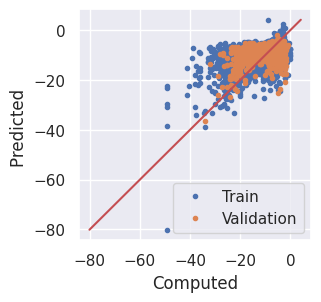

Epoch: 91, Train MAE: 2.8950, Val MAE: 2.9131
Epoch: 92, Train MAE: 2.8782, Val MAE: 2.8947
Epoch: 93, Train MAE: 2.8726, Val MAE: 2.8823
Epoch: 94, Train MAE: 2.8662, Val MAE: 2.8404
Epoch: 95, Train MAE: 2.8626, Val MAE: 2.8869
Epoch: 96, Train MAE: 2.8690, Val MAE: 2.8756
Epoch: 97, Train MAE: 2.8627, Val MAE: 2.8552
Epoch: 98, Train MAE: 2.8404, Val MAE: 2.8879
Epoch: 99, Train MAE: 2.8661, Val MAE: 2.8769
Epoch: 100, Train MAE: 2.8496, Val MAE: 2.8587


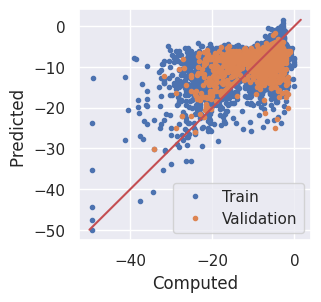

Epoch: 101, Train MAE: 2.8460, Val MAE: 2.8912
Epoch: 102, Train MAE: 2.8429, Val MAE: 2.8821
Epoch: 103, Train MAE: 2.8292, Val MAE: 2.8528
Epoch: 104, Train MAE: 2.8321, Val MAE: 2.8484
Epoch: 105, Train MAE: 2.8428, Val MAE: 2.8758
Epoch: 106, Train MAE: 2.8387, Val MAE: 2.8387
Epoch: 107, Train MAE: 2.8586, Val MAE: 2.9305
Epoch: 108, Train MAE: 2.8866, Val MAE: 2.8396
Epoch: 109, Train MAE: 2.8560, Val MAE: 2.8785
Epoch: 110, Train MAE: 2.8702, Val MAE: 2.8930


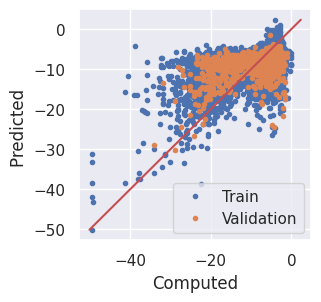

Epoch: 111, Train MAE: 2.8375, Val MAE: 2.8951
Epoch: 112, Train MAE: 2.8359, Val MAE: 2.8477
Epoch: 113, Train MAE: 2.8307, Val MAE: 2.8520
Epoch: 114, Train MAE: 2.8002, Val MAE: 2.8834
Epoch: 115, Train MAE: 2.8069, Val MAE: 2.8640
Epoch: 116, Train MAE: 2.7968, Val MAE: 2.8451
Epoch: 117, Train MAE: 2.8232, Val MAE: 2.8710
Epoch: 118, Train MAE: 2.8913, Val MAE: 2.9248
Epoch: 119, Train MAE: 2.8425, Val MAE: 2.8554
Epoch: 120, Train MAE: 2.7976, Val MAE: 2.8435


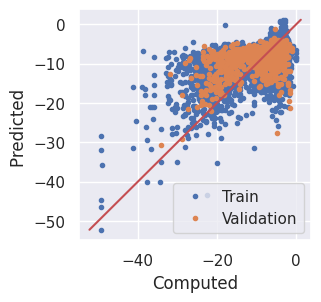

Epoch: 121, Train MAE: 2.8130, Val MAE: 2.8679
Epoch: 122, Train MAE: 2.8192, Val MAE: 2.8674
Epoch: 123, Train MAE: 2.7926, Val MAE: 2.8612
Epoch: 124, Train MAE: 2.7914, Val MAE: 2.8361
Epoch: 125, Train MAE: 2.8000, Val MAE: 2.8818
Epoch: 126, Train MAE: 2.7838, Val MAE: 2.8574
Epoch: 127, Train MAE: 2.7854, Val MAE: 2.8285
Epoch: 128, Train MAE: 2.7991, Val MAE: 2.8691
Epoch: 129, Train MAE: 2.7851, Val MAE: 2.8668
Epoch: 130, Train MAE: 2.8202, Val MAE: 2.8510


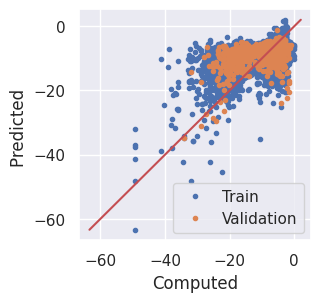

Epoch: 131, Train MAE: 2.8037, Val MAE: 2.8995
Epoch: 132, Train MAE: 2.7916, Val MAE: 2.8742
Epoch: 133, Train MAE: 2.7773, Val MAE: 2.8809
Epoch: 134, Train MAE: 2.7744, Val MAE: 2.8220
Epoch: 135, Train MAE: 2.7825, Val MAE: 2.8841
Epoch: 136, Train MAE: 2.8041, Val MAE: 2.8832
Epoch: 137, Train MAE: 2.7668, Val MAE: 2.8400
Epoch: 138, Train MAE: 2.7641, Val MAE: 2.8523
Epoch: 139, Train MAE: 2.7617, Val MAE: 2.8500
Epoch: 140, Train MAE: 2.7786, Val MAE: 2.8388


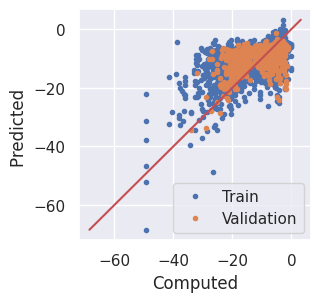

Epoch: 141, Train MAE: 2.7723, Val MAE: 2.8678
Epoch: 142, Train MAE: 2.8248, Val MAE: 2.8457
Epoch: 143, Train MAE: 2.7617, Val MAE: 2.9010
Epoch: 144, Train MAE: 2.7680, Val MAE: 2.8724
Epoch: 145, Train MAE: 2.7590, Val MAE: 2.8577
Epoch: 146, Train MAE: 2.7671, Val MAE: 2.8546
Epoch: 147, Train MAE: 2.7721, Val MAE: 2.8622
Epoch: 148, Train MAE: 2.7460, Val MAE: 2.8318
Epoch: 149, Train MAE: 2.7562, Val MAE: 2.9000
Epoch: 150, Train MAE: 2.7671, Val MAE: 2.8451


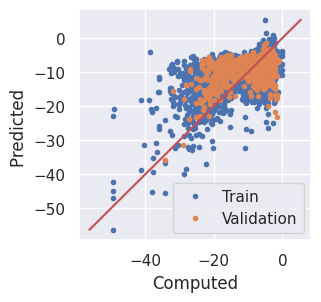

Epoch: 151, Train MAE: 2.7652, Val MAE: 2.8483
Epoch: 152, Train MAE: 2.7781, Val MAE: 2.8337
Epoch: 153, Train MAE: 2.7922, Val MAE: 2.8626
Epoch: 154, Train MAE: 2.7480, Val MAE: 2.8350
Epoch: 155, Train MAE: 2.7461, Val MAE: 2.8648
Epoch: 156, Train MAE: 2.7355, Val MAE: 2.8408
Epoch: 157, Train MAE: 2.7710, Val MAE: 2.8263
Epoch: 158, Train MAE: 2.7771, Val MAE: 2.8409
Epoch: 159, Train MAE: 2.7292, Val MAE: 2.8018
Epoch: 160, Train MAE: 2.7448, Val MAE: 2.8042


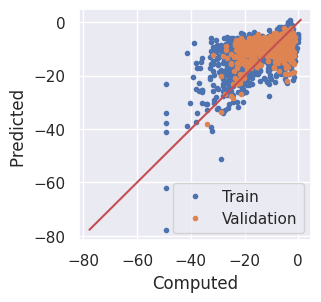

Epoch: 161, Train MAE: 2.7417, Val MAE: 2.8330
Epoch: 162, Train MAE: 2.7534, Val MAE: 2.8445
Epoch: 163, Train MAE: 2.7319, Val MAE: 2.8341
Epoch: 164, Train MAE: 2.7519, Val MAE: 2.8406
Epoch: 165, Train MAE: 2.7656, Val MAE: 2.8210
Epoch: 166, Train MAE: 2.7295, Val MAE: 2.8442
Epoch: 167, Train MAE: 2.7728, Val MAE: 2.8593
Epoch: 168, Train MAE: 2.6946, Val MAE: 2.9206
Epoch: 169, Train MAE: 2.7345, Val MAE: 2.8635
Epoch: 170, Train MAE: 2.7518, Val MAE: 2.8814


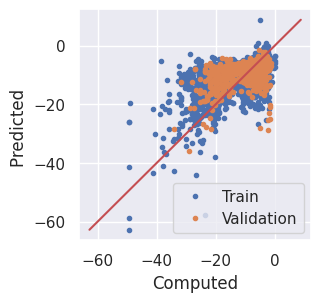

Epoch: 171, Train MAE: 2.7422, Val MAE: 2.9109
Epoch: 172, Train MAE: 2.7358, Val MAE: 2.9681
Epoch: 173, Train MAE: 2.7372, Val MAE: 2.8780
Epoch: 174, Train MAE: 2.7366, Val MAE: 2.9132
Epoch: 175, Train MAE: 2.7490, Val MAE: 2.8383
Epoch: 176, Train MAE: 2.7078, Val MAE: 2.8597
Epoch: 177, Train MAE: 2.6977, Val MAE: 2.8445
Epoch: 178, Train MAE: 2.7187, Val MAE: 2.8357
Epoch: 179, Train MAE: 2.7370, Val MAE: 2.7822
Epoch: 180, Train MAE: 2.7094, Val MAE: 2.8579


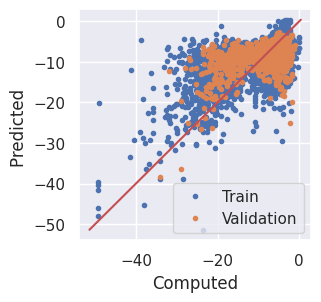

Epoch: 181, Train MAE: 2.7150, Val MAE: 2.8277
Epoch: 182, Train MAE: 2.7400, Val MAE: 2.7613
Epoch: 183, Train MAE: 2.7034, Val MAE: 2.8490
Epoch: 184, Train MAE: 2.6967, Val MAE: 2.8191
Epoch: 185, Train MAE: 2.7246, Val MAE: 2.8198
Epoch: 186, Train MAE: 2.6892, Val MAE: 2.7534
Epoch: 187, Train MAE: 2.7303, Val MAE: 2.7889
Epoch: 188, Train MAE: 2.7048, Val MAE: 2.7869
Epoch: 189, Train MAE: 2.7041, Val MAE: 2.8100
Epoch: 190, Train MAE: 2.7080, Val MAE: 2.8023


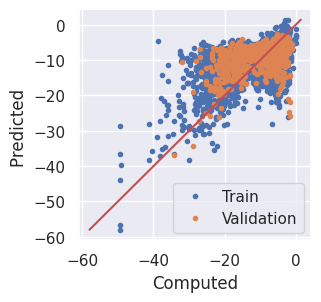

Epoch: 191, Train MAE: 2.6902, Val MAE: 2.8359
Epoch: 192, Train MAE: 2.7468, Val MAE: 2.8801
Epoch: 193, Train MAE: 2.7181, Val MAE: 2.8507
Epoch: 194, Train MAE: 2.6940, Val MAE: 2.8440
Epoch: 195, Train MAE: 2.6981, Val MAE: 2.8425
Epoch: 196, Train MAE: 2.7182, Val MAE: 2.7759
Epoch: 197, Train MAE: 2.6937, Val MAE: 2.7585
Epoch: 198, Train MAE: 2.6739, Val MAE: 2.8519
Epoch: 199, Train MAE: 2.6802, Val MAE: 2.8086
Epoch: 200, Train MAE: 2.8339, Val MAE: 2.8990


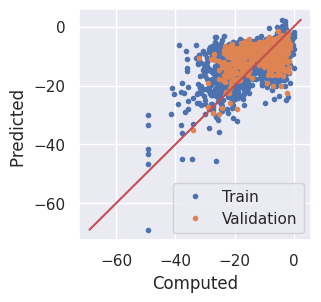

Epoch: 201, Train MAE: 2.7391, Val MAE: 2.8011
Epoch: 202, Train MAE: 2.6978, Val MAE: 2.7832
Epoch: 203, Train MAE: 2.6895, Val MAE: 2.7839
Epoch: 204, Train MAE: 2.7137, Val MAE: 2.8336
Epoch: 205, Train MAE: 2.6994, Val MAE: 2.8046
Epoch: 206, Train MAE: 2.6882, Val MAE: 2.7988
Epoch: 207, Train MAE: 2.7024, Val MAE: 2.8209
Epoch: 208, Train MAE: 2.6828, Val MAE: 2.8050
Epoch: 209, Train MAE: 2.6610, Val MAE: 2.8061
Epoch: 210, Train MAE: 2.6916, Val MAE: 2.7917


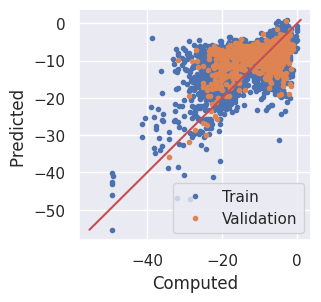

Epoch: 211, Train MAE: 2.6826, Val MAE: 2.7731
Epoch: 212, Train MAE: 2.6981, Val MAE: 2.8192
Epoch: 213, Train MAE: 2.7213, Val MAE: 2.8435
Epoch: 214, Train MAE: 2.6838, Val MAE: 2.8269
Epoch: 215, Train MAE: 2.6668, Val MAE: 2.8065
Epoch: 216, Train MAE: 2.6747, Val MAE: 2.7690
Epoch: 217, Train MAE: 2.6667, Val MAE: 2.7901
Epoch: 218, Train MAE: 2.6813, Val MAE: 2.7977
Epoch: 219, Train MAE: 2.6798, Val MAE: 2.7874
Epoch: 220, Train MAE: 2.6916, Val MAE: 2.7572


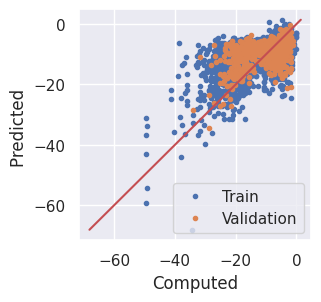

Epoch: 221, Train MAE: 2.6910, Val MAE: 2.7857
Epoch: 222, Train MAE: 2.6770, Val MAE: 2.8436
Epoch: 223, Train MAE: 2.6895, Val MAE: 2.7836
Epoch: 224, Train MAE: 2.7255, Val MAE: 2.8690
Epoch: 225, Train MAE: 2.6913, Val MAE: 2.8034
Epoch: 226, Train MAE: 2.6863, Val MAE: 2.8580
Epoch: 227, Train MAE: 2.6707, Val MAE: 2.7793
Epoch: 228, Train MAE: 2.6780, Val MAE: 2.7953
Epoch: 229, Train MAE: 2.6470, Val MAE: 2.8190
Epoch: 230, Train MAE: 2.6971, Val MAE: 2.8104


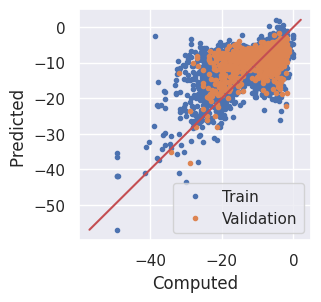

Epoch: 231, Train MAE: 2.6683, Val MAE: 2.7613
Epoch: 232, Train MAE: 2.6427, Val MAE: 2.8170
Epoch: 233, Train MAE: 2.6603, Val MAE: 2.8249
Epoch: 234, Train MAE: 2.6506, Val MAE: 2.8032
Epoch: 235, Train MAE: 2.6347, Val MAE: 2.8535
Epoch: 236, Train MAE: 2.6623, Val MAE: 2.8484
Epoch: 237, Train MAE: 2.6553, Val MAE: 2.8376
Epoch: 238, Train MAE: 2.7226, Val MAE: 2.8385
Epoch: 239, Train MAE: 2.6701, Val MAE: 2.8234
Epoch: 240, Train MAE: 2.6853, Val MAE: 2.8212


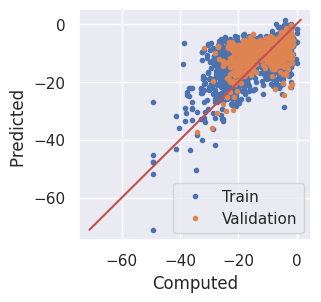

Epoch: 241, Train MAE: 2.6633, Val MAE: 2.8182
Epoch: 242, Train MAE: 2.6432, Val MAE: 2.7651
Epoch: 243, Train MAE: 2.6271, Val MAE: 2.7772
Epoch: 244, Train MAE: 2.6321, Val MAE: 2.8352
Epoch: 245, Train MAE: 2.6495, Val MAE: 2.7909
Epoch: 246, Train MAE: 2.6388, Val MAE: 2.7894
Epoch: 247, Train MAE: 2.6415, Val MAE: 2.7881
Epoch: 248, Train MAE: 2.6453, Val MAE: 2.9224
Epoch: 249, Train MAE: 2.6585, Val MAE: 2.7897
Epoch: 250, Train MAE: 2.6369, Val MAE: 2.8445


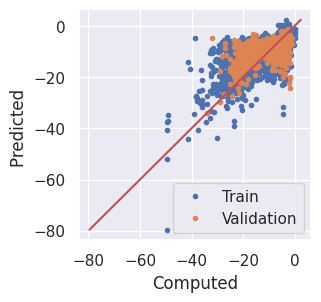

Epoch: 251, Train MAE: 2.6479, Val MAE: 2.8307
Epoch: 252, Train MAE: 2.6605, Val MAE: 2.7926
Epoch: 253, Train MAE: 2.6426, Val MAE: 2.9070
Epoch: 254, Train MAE: 2.6677, Val MAE: 2.9486
Epoch: 255, Train MAE: 2.6770, Val MAE: 2.7603
Epoch: 256, Train MAE: 2.6237, Val MAE: 2.7992
Epoch: 257, Train MAE: 2.6397, Val MAE: 2.7902
Epoch: 258, Train MAE: 2.6438, Val MAE: 2.7746
Epoch: 259, Train MAE: 2.6315, Val MAE: 2.8263
Epoch: 260, Train MAE: 2.6420, Val MAE: 2.8551


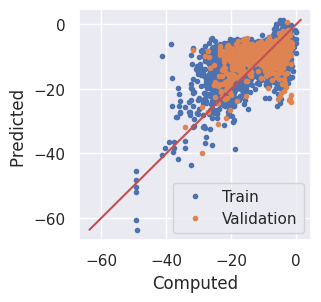

Epoch: 261, Train MAE: 2.6235, Val MAE: 2.8640
Epoch: 262, Train MAE: 2.6315, Val MAE: 2.8409
Epoch: 263, Train MAE: 2.6412, Val MAE: 2.7942
Epoch: 264, Train MAE: 2.6463, Val MAE: 2.8426
Epoch: 265, Train MAE: 2.7675, Val MAE: 2.8247
Epoch: 266, Train MAE: 2.6817, Val MAE: 2.8251
Epoch: 267, Train MAE: 2.6391, Val MAE: 2.8440
Epoch: 268, Train MAE: 2.6198, Val MAE: 2.8202
Epoch: 269, Train MAE: 2.6289, Val MAE: 2.7827
Epoch: 270, Train MAE: 2.6217, Val MAE: 2.8325


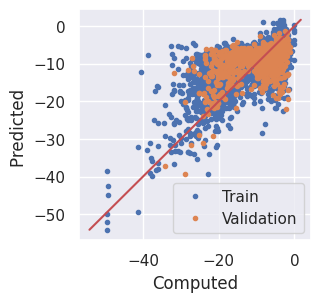

Epoch: 271, Train MAE: 2.6186, Val MAE: 2.7942
Epoch: 272, Train MAE: 2.6252, Val MAE: 2.8180
Epoch: 273, Train MAE: 2.6259, Val MAE: 2.7688
Epoch: 274, Train MAE: 2.6841, Val MAE: 2.8168
Epoch: 275, Train MAE: 2.6962, Val MAE: 2.8130
Epoch: 276, Train MAE: 2.6345, Val MAE: 2.8048
Epoch: 277, Train MAE: 2.6439, Val MAE: 2.8924
Epoch: 278, Train MAE: 2.6287, Val MAE: 2.7892
Epoch: 279, Train MAE: 2.6103, Val MAE: 2.8367
Epoch: 280, Train MAE: 2.6208, Val MAE: 2.8035


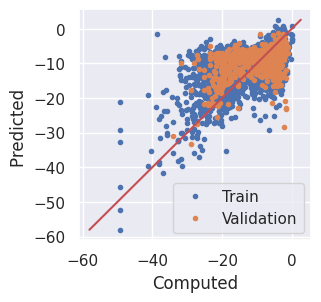

Epoch: 281, Train MAE: 2.6566, Val MAE: 2.8511
Epoch: 282, Train MAE: 2.6173, Val MAE: 2.8412
Epoch: 283, Train MAE: 2.6023, Val MAE: 2.7944
Epoch: 284, Train MAE: 2.6521, Val MAE: 2.7946
Epoch: 285, Train MAE: 2.6081, Val MAE: 2.8043
Epoch: 286, Train MAE: 2.6293, Val MAE: 2.9091
Epoch: 287, Train MAE: 2.5944, Val MAE: 2.8191
Epoch: 288, Train MAE: 2.6218, Val MAE: 2.8670
Epoch: 289, Train MAE: 2.7278, Val MAE: 2.8910
Epoch: 290, Train MAE: 2.6352, Val MAE: 2.8998


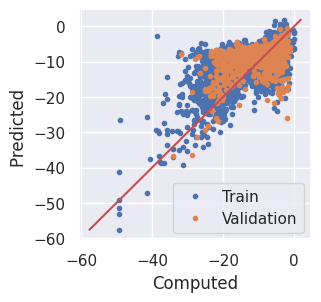

Epoch: 291, Train MAE: 2.5940, Val MAE: 2.8184
Epoch: 292, Train MAE: 2.6351, Val MAE: 2.7872
Epoch: 293, Train MAE: 2.6311, Val MAE: 2.8129
Epoch: 294, Train MAE: 2.6367, Val MAE: 2.7796
Epoch: 295, Train MAE: 2.6245, Val MAE: 2.8410
Epoch: 296, Train MAE: 2.6238, Val MAE: 2.8677
Epoch: 297, Train MAE: 2.6473, Val MAE: 2.8370
Epoch: 298, Train MAE: 2.6475, Val MAE: 2.8172
Epoch: 299, Train MAE: 2.6274, Val MAE: 2.7743
Epoch: 300, Train MAE: 2.5982, Val MAE: 2.8085


In [9]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = clm.train(model, criterion, train_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'],
                                                                   optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'])

    # Convert to original units
    train_loss = np.sum(np.sqrt(train_loss) * target_factor)
    val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)

    if epoch%10 == 0:
        cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                        validation=np.array([val_ground_truths, val_predictions]))
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

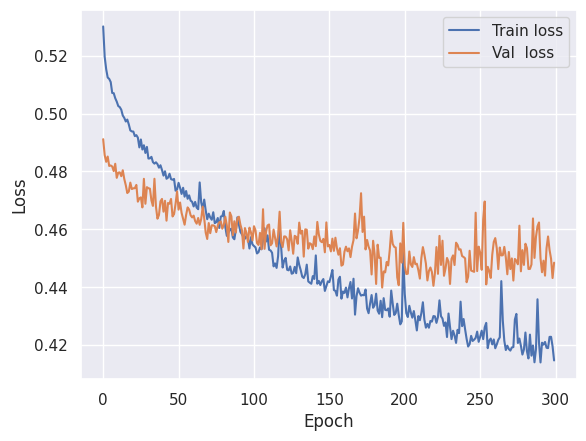

In [10]:
cld.losses_plot(train_losses=train_losses,
                val_losses=val_losses,
                to_log=True)

# Check test data

In [11]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model_name'], purpose='eval')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

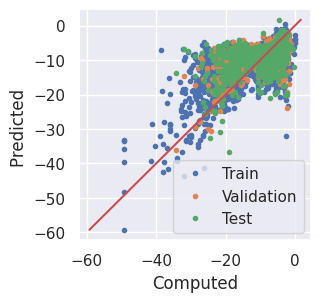

Train MAE: 2.5557, Val MAE: 2.7534, Test MAE: 2.9057


In [12]:
train_loss, train_predictions, train_ground_truths = clm.test(model, criterion, train_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                               target_factor,
                                                               standardized_parameters['target_mean'])
test_loss,  test_predictions,  test_ground_truths  =  clm.test(model, criterion, test_loader,
                                                               target_factor,
                                                               standardized_parameters['target_mean'])

# Pass to energy units (same as initial Fv)
train_loss = np.sum(np.sqrt(train_loss) * target_factor)
val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)
test_loss  = np.sum(np.sqrt(test_loss)  * target_factor)

cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                validation=np.array([val_ground_truths, val_predictions]),
                test=np.array([test_ground_truths, test_predictions]),
                save_to=f'{target_folder}/{target}-GCNN-training.pdf')

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

# Generate uncertainties and save

In [13]:
dataset = [data for dataset in [train_dataset, val_dataset, test_dataset] for data in dataset]

loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

loss, predictions, ground_truths = clm.test(model, criterion, loader,
                                            target_factor,
                                            standardized_parameters['target_mean'])

# label: uncertainty = ground-truth - prediction
uncertainties = ground_truths - predictions

# Standardize for better interpolation
#uncert_mean  = uncertainties.mean()
#uncert_std   = uncertainties.std()

#uncert_mean = 0
#uncert_std  = 1

uncert_mean  = standardized_parameters['target_mean']
uncert_std   = standardized_parameters['target_std']

uncertainties_std = (uncertainties - uncert_mean) * standardized_parameters['scale'] / uncert_std

# Generate dictionary with uncertainty data
uncertainty_values = {}
for idx in range(len(dataset)):
    uncertainty_values.update(
        {dataset[idx].label: float(uncertainties_std[idx])}
    )
uncertainty_data = {
    'uncertainty_values': uncertainty_values,
    'uncert_mean':        uncert_mean,
    'uncert_std':         uncert_std
}

# Dump the dictionary with numpy arrays to a JSON file
cld.save_json(uncertainty_data, files_names['uncert_data_name'])

In [14]:
uncertainty_values

{'LaNb3O9-C2-m': 325.03551710951115,
 'MnPdAu2-Immm': 1043.1220594774463,
 'Pr2MgS4-I-42d': 521.180203093169,
 'CsVP2O7-P2_1-c': 401.24206460821415,
 'Na3MgNbSi2SO12-Cc': 420.78230918752934,
 'Ba2DyBiO6-Pn-3': 462.40097965109135,
 'MnVSbO6-Pbcn': 400.4761480222919,
 'K3Zr6BeCl15-C2-c': 520.0459276567676,
 'NaAl6Fe3Si6B3H3O30F-R3m': 390.62821163046146,
 'Sb(IF3)2-P-1': 629.813425673125,
 'LiVPH4O7-Cmce': 398.62444366323734,
 'AlP3NO10-P2-c': 427.4573866258838,
 'K17Fe5O16-Cm': 515.7751394640186,
 'Cs3SbI6-Fm-3m': 476.94760574209477,
 'Li3PS4-Pnma': 388.5334936510303,
 'Sr15Ti23O61-P2-m': 231.50333846914555,
 'MgGe2WO6-P2_1-c': 427.2648955713489,
 'LiCuSbO4-P2_1': 491.1899458299854,
 'Cu2H12C4Br3N-Pnma': 460.02230514395023,
 'Cs4Fe(MoO4)3-Cc': 427.89199413168217,
 'KSmS2O9-P2_1-c': 469.7811697851398,
 'LiFePO4-P2': 404.0696016679981,
 'Ba2SrI6-P4_2-mnm': 427.7141615282276,
 'Na14Mg4Si7Sn4S5O48-P1': 450.3443075548389,
 'Sr2SnO4-Pccn': 148.64590896475102,
 'SrCaMg14O16-P4-mmm': 421.3334165